# Phase 2 - Milestone 2

## 1 - Perkenalan

- Nama : Fadhil Muhammad Irfan
- Batch : FTDS-10

### Tujuan

- Melakukan klasifikasi citra dari objek kendaraan (vehicle) dan bukan kendaraan (non-vehicle)

## 2 - Import Library

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

## 3 - Load Dataset

In [ ]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

cp: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘./kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d brsdincer/vehicle-detection-image-set

vehicle-detection-image-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q /content/vehicle-detection-image-set.zip -d images #images adalah nama folder

replace images/data/non-vehicles/extra1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
os.listdir('/content/images/data')

['non-vehicles', 'vehicles']

Mengubah path directory menjadi DataFrame

In [ ]:
sdir="/content/images/data"

filepaths=[] # list filepath
labels=[] # list label
classlist=os.listdir(sdir) # list directory data (vehicle dan non vehicle)
for i in classlist:
    classpath=os.path.join(sdir,i) # menggabungkan sdir dengan classlist
    if os.path.isdir(classpath): 
        flist=os.listdir(classpath)
        for x in flist:
            fpath=os.path.join(classpath,x) # menggabungkan dir di flist
            filepaths.append(fpath)
            labels.append(i)                   

data = pd.DataFrame(filepaths, columns=["image"])
y = pd.DataFrame(labels, columns=['target'])  
df=pd.concat([data, y], axis=1)
print (df.head())


                                             image        target
0  /content/images/data/non-vehicles/extra1924.png  non-vehicles
1  /content/images/data/non-vehicles/extra4119.png  non-vehicles
2  /content/images/data/non-vehicles/image1635.png  non-vehicles
3  /content/images/data/non-vehicles/image1071.png  non-vehicles
4   /content/images/data/non-vehicles/image587.png  non-vehicles


## 4 - Data Exploration

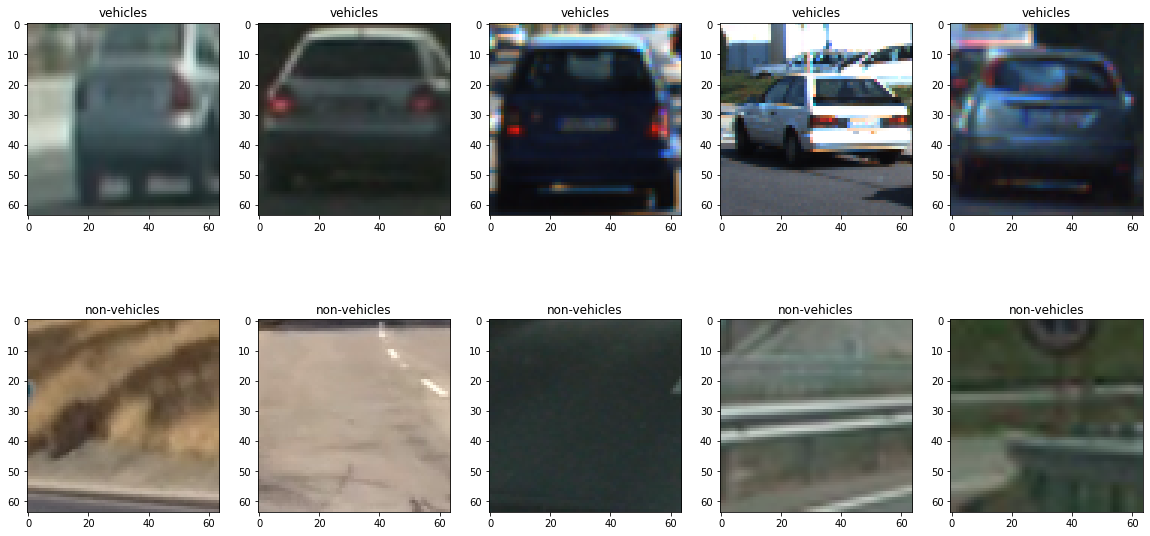

In [ ]:
# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

vehicle = (df[df['target']=='vehicles']['image'].iloc[:5]).tolist()
non_vehicle = (df[df['target']=='non-vehicles']['image'].iloc[:5]).tolist()

visualize_samples(vehicle + non_vehicle)

Dari gambar diatas bisa dilihat jika:
- gambar vehicle teridiri dari foto belakang mobil
- gambar non vehicle terdiri dari jalan, dan pembatas jalan
- Shape dari gambar menunjukkan sekitar 60 x 60 semuanya sehingga tidak perlu reshape

In [ ]:
x = [0, 1, 2, 3, 4]
for i in x:
  veh_shape = plt.imread(vehicle[i])
  nonveh_shape = plt.imread(non_vehicle[i])
  print(veh_shape.shape)
  print(nonveh_shape.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


Untuk membuktikkan pernyataan terakhir disebelumnya digunakan `.shape` untuk mengetahui bentuk matriks setiap gambar:
- matrix gambar ini mempunyai shape 64, 64, 3. Dikarenakan size dari setiap gambar sudah sama maka tidak ada reshaping selama data preprocessing

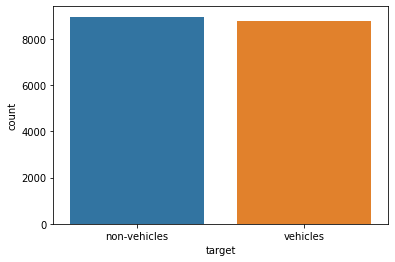

In [ ]:
sns.countplot(data=df, x='target')

Berdasarkan `countplot()` diatas:
- vehicle dan non-vehicle mempunyai rasio yang seimbang 
- sehingga data nya cukup balance

## 5 - Data Preprocessing

In [ ]:
img_height= 64
img_width= 64
SEED = 1
BATCH =64

# biar output notebooknya stabil
np.random.seed(42)
tf.random.set_seed(42)

mengubah bentuk matrix / size gambar menjadi 64 x 64, dikhawatirkan masih ada gambar yang ukurannya belum sama, dan agar saat ada data baru (data inference) bisa disamakan ukurannya

### Split Data Train, Val, and Test

In [ ]:
train, test = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=20)
train, val = train_test_split(train, test_size=0.3, stratify=train['target'], random_state=20)

### Melakukan data normalisasi

In [ ]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Menyimpan data menjadi satu pipeline dengan tensorflow pipeline

In [ ]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train, # nama dataset yang mau dimasukin
    x_col='image', # colom input
    y_col='target', # colom target
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='categorical',
    batch_size=BATCH, # jumlah batch
    shuffle=True,
    seed=SEED) # seed number

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='target',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='target',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 9945 validated image filenames belonging to 2 classes.
Found 4263 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


Untuk classmode yang digunakan adalah categorical yang artinya prosesnya seperti multiclass dimana di output layer akan digunakan 2 neuron. 

Walaupun aslinya, model ini bisa menggunakan binary dikarenakan jumlah kelas nya adalah 2. Pada percobaan ini, saya ingin memperlakukan model ini sebagai multiclass demi pembelajaran atau explorasi

In [ ]:
ds_train.class_indices

{'non-vehicles': 0, 'vehicles': 1}

Terdapat 2 kelas non vehicle dan vehicle

## 6 - Model Definition

Pada base model, akan digunakan:
- 2 conv layer
- 1 flatten layer
- 1 fully connected layer
- output layer

**SEQUENTIAL API**

In [ ]:
input= [img_height,img_width,3]

model= Sequential()

#Conv 1
model.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input))
model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten dan Fully Connected
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))

# Output
model.add(Dense(units=2, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 6272)              0         
                                                                 
 dense_16 (Dense)            (None, 128)              

**FUNCTIONAL API**

In [ ]:
# input
input = Input(shape=input)

# Conv 1
conv1 = Conv2D(filters=16,kernel_size=3, activation= 'relu')(input)
pool1 = MaxPooling2D(pool_size=2, strides=2)(conv1)

# Conv 2
conv2 = Conv2D(filters=32,kernel_size=3, activation= 'relu')(pool1)
pool2 = MaxPooling2D(pool_size=2, strides=2)(conv2)

#flatten and fully connected layer
flat = Flatten()(pool2)
hid1 = Dense(units=128, activation='relu')(flat)

# output
output = Dense(units=2, activation='sigmoid')(hid1)
model1 = Model(inputs=input, outputs=output)


# Compile
model1.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])
model1.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 6272)              0   

## 7 - Model Training

**SEQUENTIAL**

In [ ]:
epochs=10
history= model.fit(ds_train, batch_size= BATCH, epochs=epochs, 
                          validation_data= ds_val, verbose=1)

Epoch 1/10
156/156 [==============================] - 18s 111ms/step - loss: 0.2768 - accuracy: 0.8808 - val_loss: 0.1133 - val_accuracy: 0.9627
Epoch 2/10
156/156 [==============================] - 17s 109ms/step - loss: 0.1427 - accuracy: 0.9446 - val_loss: 0.1202 - val_accuracy: 0.9587
Epoch 3/10
156/156 [==============================] - 17s 111ms/step - loss: 0.1090 - accuracy: 0.9582 - val_loss: 0.0598 - val_accuracy: 0.9798
Epoch 4/10
156/156 [==============================] - 17s 110ms/step - loss: 0.1030 - accuracy: 0.9619 - val_loss: 0.0611 - val_accuracy: 0.9808
Epoch 5/10
156/156 [==============================] - 17s 111ms/step - loss: 0.0805 - accuracy: 0.9693 - val_loss: 0.0449 - val_accuracy: 0.9850
Epoch 6/10
156/156 [==============================] - 17s 110ms/step - loss: 0.0739 - accuracy: 0.9748 - val_loss: 0.0737 - val_accuracy: 0.9742
Epoch 7/10
156/156 [==============================] - 18s 116ms/step - loss: 0.0638 - accuracy: 0.9782 - val_loss: 0.0345 - val_ac

**FUNCTIONAL**

In [ ]:
epochs=10
history1= model1.fit(ds_train, batch_size= BATCH, epochs=epochs, 
                          validation_data= ds_val, verbose=1)

Epoch 1/10
156/156 [==============================] - 18s 110ms/step - loss: 0.3091 - accuracy: 0.8587 - val_loss: 0.1592 - val_accuracy: 0.9313
Epoch 2/10
156/156 [==============================] - 17s 110ms/step - loss: 0.1450 - accuracy: 0.9437 - val_loss: 0.0950 - val_accuracy: 0.9679
Epoch 3/10
156/156 [==============================] - 17s 109ms/step - loss: 0.1219 - accuracy: 0.9547 - val_loss: 0.0863 - val_accuracy: 0.9679
Epoch 4/10
156/156 [==============================] - 17s 108ms/step - loss: 0.0923 - accuracy: 0.9665 - val_loss: 0.0491 - val_accuracy: 0.9826
Epoch 5/10
156/156 [==============================] - 17s 108ms/step - loss: 0.1016 - accuracy: 0.9654 - val_loss: 0.0598 - val_accuracy: 0.9810
Epoch 6/10
156/156 [==============================] - 17s 108ms/step - loss: 0.0817 - accuracy: 0.9711 - val_loss: 0.0604 - val_accuracy: 0.9798
Epoch 7/10
156/156 [==============================] - 17s 108ms/step - loss: 0.0726 - accuracy: 0.9747 - val_loss: 0.0354 - val_ac

## 8 - Model Evaluation

**SEQUENTIAL**

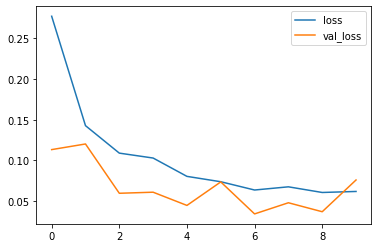

In [ ]:
metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot();

- Setelah epoch ke 10, model sudah tidak overfit.
- Dari epoch ke 1 - 10, loss masih menurun sehingga diperkirakan jika model ini akan lebih baik saat menggunakan epoch besar

In [ ]:
test_steps_per_epoch = np.math.ceil(df_test.samples / df_test.batch_size)
loss, acc = model.evaluate_generator(generator=df_test,
steps=test_steps_per_epoch)

print('loss:', loss)
print('accuracy:', acc)

loss: 0.07518476247787476
accuracy: 0.974380612373352


Akurasi dari nilai test nya adalah 0.97 yang berati model ini sudah cukup baik untuk membedakan mana kendaraan dan bukan kendaraan

In [ ]:
X_test = test['image']
y_test = test['target']

In [ ]:
df_test.reset()
pred=model.predict_generator(df_test,
steps=test_steps_per_epoch,
verbose=1)

56/56 [==============================] - 2s 26ms/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (ds_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

non-vehicles       1.00      0.95      0.97      1794
    vehicles       0.95      1.00      0.97      1758

    accuracy                           0.97      3552
   macro avg       0.98      0.97      0.97      3552
weighted avg       0.98      0.97      0.97      3552



Dilihat dari classification report:
- Nilai recall dari vehicles mencapai 100 persen tetapi, precisionnya adalah 0.95 persen. Hal ini berarti masih ada True Negative di model ini
- Nilai recall di non-vehicles adalah 95% sedangkan precisionnya 100 persen. Yang artinya False Negative untuk non-vehicles masih ada.

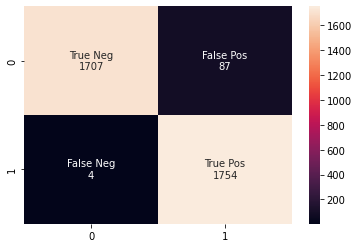

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_count = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_count)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

- Jumlah False Positive (non vehicles tertebak vehicles) - 87
- Jumlah False Negative (vehicles tertebak non vehicles) - 4

Secara keseluruhan untuk model (sequential)
- model tidak overfit
- akurasi mencapai 97 persen sehingga dapat dibilang kalau model ini sangat baik
- Jumlah error di FP dan FN tidak banyak atau dibawah 100
- Model ini sudah baik untuk digunakan

**FUNCTIONAL**

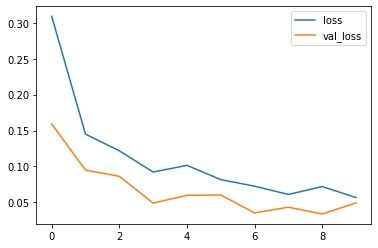

In [ ]:
metrics1 = pd.DataFrame(history1.history)
metrics1[['loss', 'val_loss']].plot();

- Setelah epoch ke 10 model tidak overfit
- Model mengalami penurunan dari epoch ke 1 sampai ke 10

In [ ]:
loss, acc = model1.evaluate_generator(generator=df_test,
steps=test_steps_per_epoch)

print('loss:', loss)
print('accuracy:', acc)

loss: 0.048157233744859695
accuracy: 0.9873310923576355


Akurasi dari permodelan ini adlaah 0.99. Yang artinya model ini mengalami peningkatan dan lebih baik daripada model sequential 

In [ ]:
df_test.reset()
pred1=model1.predict_generator(df_test,
steps=test_steps_per_epoch,
verbose=1)

56/56 [==============================] - 2s 27ms/step


In [ ]:
predicted_class_indices=np.argmax(pred1, axis=1)
labels = (ds_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]
print(classification_report(y_test, predictions1))

              precision    recall  f1-score   support

non-vehicles       1.00      0.98      0.99      1794
    vehicles       0.98      1.00      0.99      1758

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



Dilihat dari classification report:
- Nilai recall dari vehicles mencapai 1.00 tetapi, precisionnya adalah 0.98. Hal ini berarti masih ada True Negative di model ini yang dimana jumlahnya lebih sedikit dibandingkan model Sequential
- Nilai recall di non-vehicles adalah 0.98 sedangkan precisionnya 100 persen. Yang artinya False Negative untuk non-vehicles masih ada tetapi jumlahnya lebih sedikit dibandingkan model sequential

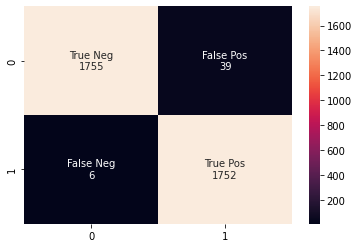

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions1)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_count = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_count)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

- Jumlah False Positive (non vehicles tertebak vehicles) - 39 yang artinya terdapay penurunan sebanyak 1/2 kali dari sequential
- Jumlah False Negative (vehicles tertebak non vehicles) - 6 yang dimana terdapat 2 error lebih banyak dibandingkan model sequential

Secara keseluruhan untuk model 1 (functional)
- model tidak overfit
- akurasi mencapai 99 persen sehingga dapat dibilang kalau model ini sangat baik bahkan mencapai 100 persen
- Jumlah error di FP dan FN tidak banyak atau dibawah 100 yang artinya tidaklah seignifikan
- Model ini sudah baik untuk digunakan dan lebih baik dibandingkan model sequential

## 9 - Model Imporvement

Walaupun modelnya sudah bagus yang dimana akurasinya diatas 0.95, tetapi kali ini saya akan tetap mencoba melakukan model improvement dengan:

Model 2:
- menggunakan transfer learning yaitu Resnet50 (agar conv2d layer lebih banyak)
- menambah jumlah Epoch dan callback (agar terlihat model saat maksimum)

Model 3:
- menambah 3 convultion layer baru
- menambah jumlah epoch dan callback

Pada improvement kali ini, permodelan akan ditulis dengan Sequential API. Hal ini dikarenakan, seharusnya tidak ada hubungan antara teknik penulisan dengan nilai akurasinya. Hanya saja pada percobaan (atau running notebook) kali  ini model functional API mendapatkan akurasi yang lebih baik. Terlebih lagi, pada percobaan-percobaan sebelumnya atau running sebelumnya (yang tidak dapat ditampilkan pada notebook ini), model sequential mendapatkan akurasi diatas Functional API.

### Model Definition

**MODEL 2: RESNET50**

In [ ]:
base_model=tf.keras.applications.ResNet50(input_shape=(64,64,3),include_top=False,weights='imagenet')

model2=tf.keras.Sequential()

# Convulutional layer
model2.add(base_model)

# Flatten dan Fully Connected layer
model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))

# Output
model2.add(Dense(units=2, activation='sigmoid')) 

# Compile
model2.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])
model2.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               1048704   
                                                                 
 dense_21 (Dense)            (None, 2)                 258       
                                                                 
Total params: 24,636,674
Trainable params: 24,583,554
Non-trainable params: 53,120
_________________________________________________________________


**MODEL3: Adding 3 Conv Layer**

In [ ]:
model3=tf.keras.Sequential()

# Convulutional layer
#Conv 1
model3.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape=(64,64,3)))
model3.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model3.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
model3.add(MaxPooling2D(pool_size=2, strides=2))

# Conv 3
model3.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model3.add(MaxPooling2D(pool_size=2, strides=2))

# Conv 4
model3.add(Conv2D(filters=128,kernel_size=3, activation= 'relu'))

# Conv 5
model3.add(Conv2D(filters=256,kernel_size=3, activation= 'relu'))


# Flatten dan Fully Connected layer
model3.add(Flatten())
model3.add(Dense(units=128, activation='relu'))

# Output
model3.add(Dense(units=2, activation='sigmoid')) 

# Compile
model3.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 6, 6, 64)        

### Model Training

Callback dengan early stopping yang dimana saat val loss tidak menurun setelah 3 epoch, maka model akan di stop

In [ ]:
callback = EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 3, verbose=1)

MODEL 2: Dengan Resnet550

In [ ]:
epochs=100
history2= model2.fit(ds_train, batch_size= BATCH, epochs=epochs, 
                          validation_data= ds_val, callbacks=callback, verbose=1)

Epoch 1/100
156/156 [==============================] - 29s 148ms/step - loss: 0.1465 - accuracy: 0.9707 - val_loss: 20.9416 - val_accuracy: 0.5050
Epoch 2/100
156/156 [==============================] - 22s 141ms/step - loss: 0.0301 - accuracy: 0.9917 - val_loss: 8.9711 - val_accuracy: 0.5050
Epoch 3/100
156/156 [==============================] - 22s 140ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 9.3555 - val_accuracy: 0.5050
Epoch 4/100
156/156 [==============================] - 22s 142ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 5.2801 - val_accuracy: 0.5194
Epoch 5/100
156/156 [==============================] - 22s 142ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 3.6060 - val_accuracy: 0.6629
Epoch 6/100
156/156 [==============================] - 22s 140ms/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.1380 - val_accuracy: 0.9686
Epoch 7/100
156/156 [==============================] - 22s 141ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.1059 

MODEL 3: menambahkan 3 layer convulution

In [ ]:
epochs=100
history3= model3.fit(ds_train, batch_size= BATCH, epochs=epochs, 
                          validation_data= ds_val, callbacks=callback, verbose=1)

Epoch 1/100
156/156 [==============================] - 18s 109ms/step - loss: 0.2791 - accuracy: 0.8784 - val_loss: 0.1008 - val_accuracy: 0.9648
Epoch 2/100
156/156 [==============================] - 17s 108ms/step - loss: 0.1275 - accuracy: 0.9504 - val_loss: 0.1406 - val_accuracy: 0.9531
Epoch 3/100
156/156 [==============================] - 17s 108ms/step - loss: 0.1007 - accuracy: 0.9642 - val_loss: 0.0386 - val_accuracy: 0.9857
Epoch 4/100
156/156 [==============================] - 17s 109ms/step - loss: 0.0694 - accuracy: 0.9749 - val_loss: 0.0287 - val_accuracy: 0.9904
Epoch 5/100
156/156 [==============================] - 17s 108ms/step - loss: 0.0590 - accuracy: 0.9790 - val_loss: 0.0276 - val_accuracy: 0.9899
Epoch 6/100
156/156 [==============================] - 17s 109ms/step - loss: 0.0511 - accuracy: 0.9820 - val_loss: 0.0284 - val_accuracy: 0.9904
Epoch 7/100
156/156 [==============================] - 17s 108ms/step - loss: 0.0526 - accuracy: 0.9808 - val_loss: 0.0333 -

### Model Evaluation

**MODEL 2**

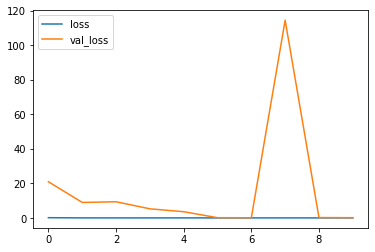

In [ ]:
metrics2 = pd.DataFrame(history2.history)
metrics2[['loss', 'val_loss']].plot();

- Dilihat dari grafik diatas dapat dikatakan bahwa model 2 dengan resnet mengalami vanishing gradient
- pada epoch ke 7 terdapat lonjakan yang ektrem pada val loss, sehingga diperkirakan model ini masih tidak stabil
- Dengan callback, maka model yang tersimpan adalah epoch ke 5. 

In [ ]:
df_test.reset()
pred2=model2.predict_generator(df_test,
steps=test_steps_per_epoch,
verbose=1)

56/56 [==============================] - 3s 36ms/step


In [ ]:
predicted_class_indices=np.argmax(pred2, axis=1)
labels = (ds_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions2 = [labels[k] for k in predicted_class_indices]
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

non-vehicles       0.79      0.99      0.88      1794
    vehicles       0.98      0.74      0.84      1758

    accuracy                           0.86      3552
   macro avg       0.89      0.86      0.86      3552
weighted avg       0.89      0.86      0.86      3552



Berdasarkan classification report:
- Nilai akurasi 0.86 yang artinya model ini jauh lebih buruk dibandingkan base model
- Nilai precision, recall, dan f1score tidak lebih baik daripada base model. Sehingga error untuk FP dan FN jauh lebih banyak daripada sebelumnya
- Dibandingkan dengan nilai akurasi dan val akurasi pada model training ini, model ini tampak belum stabil atau bisa jadi model ini masih overfit

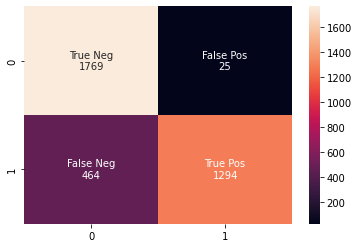

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions2)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_count = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_count)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

- Jumlah False Positive (non vehicles tertebak vehicles) - 25 yang artinya error lebih sedikit dibandingkan base model
- Jumlah False Negative (vehicles tertebak non vehicles) - 464 yang artinya error disini jauh lebih banyak dibandingkan base model

Secara keseluruhan untuk model 2 (Resnet50)
- model belum stabil atau overfit
- akurasi 0.86 yang artinya model ini tidak lebih baik dari base model

**MODEL 3**

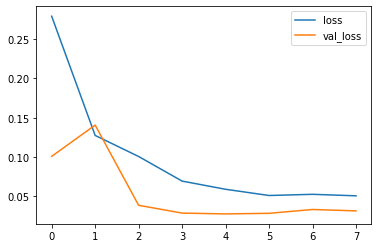

In [ ]:
metrics3 = pd.DataFrame(history3.history)
metrics3[['loss', 'val_loss']].plot();

Berdasarkan grafik loss dan val loss:
- model ini belum overfit dikarenakan jarak loss dan val loss tidak terlalu besar
- epoch yang tersimpan adalah epoch ke 5

In [ ]:
df_test.reset()
pred3=model3.predict_generator(df_test,
steps=test_steps_per_epoch,
verbose=1)

56/56 [==============================] - 2s 26ms/step


In [ ]:
predicted_class_indices=np.argmax(pred3, axis=1)
labels = (ds_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions3 = [labels[k] for k in predicted_class_indices]
print(classification_report(y_test, predictions1))

              precision    recall  f1-score   support

non-vehicles       1.00      0.98      0.99      1794
    vehicles       0.98      1.00      0.99      1758

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



Berdasarkan classification report:
- model ini mirip dengan model functional API pada base model
- Sehingga tidak terlihat ada improvement dari nilai precision, recall, f1score, dan akurasi

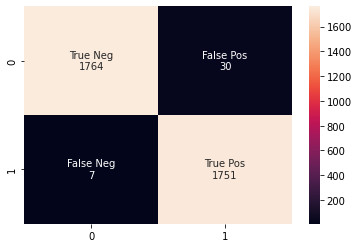

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions3)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_count = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_count)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

- Jumlah False Positive (non vehicles tertebak vehicles) - 30 yang artinya terdapay pengurangan 9 error dari base model (functional)
- Jumlah False Negative (vehicles tertebak non vehicles) - 7 yang dimana terdapat 1 error lebih banyak dibandingkan base model (functional)

Secara keseluruhan untuk model 3 (Penambahan 3 layer conv)
- model tidak overfit
- akurasi mencapai 99 persen sehingga dapat dibilang kalau model ini sangat baik bahkan mencapai 100 persen
- Jumlah error di FP dan FN tidak banyak atau dibawah 100 yang artinya tidaklah seignifikan errornya
- Model ini sedikit lebih baik dibandingkan base model functional dikarenakan nilai error di False Positive yang lebih sedikit.

**MODEL TERPILIH**

model terpilih adalah model 3 dikarenakan akurasinya paling tinggi dan juga FP paling sedikit dibandingkan model lainnya.

maka mdel yang akan di save adalah model 3 yang dimana terdapat penambahan 3 layer conv dari base model

In [ ]:
model3.save("model1.h5")

## 10 - Model Inference

Load Model

In [ ]:
model_inf = load_model("model1.h5")

Membuat funsi prediksi dan normalisasi

In [ ]:
def predict(image_data):
  size = (64, 64)    
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  image = np.asarray(image)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img_reshape = img[np.newaxis,...]
      
  prediction = model.predict(img_reshape)
  return prediction

**Prediksi untuk objek vehicle**

[[0. 1.]]
vehicle


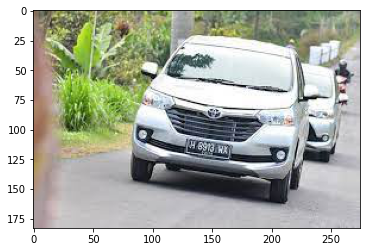

In [ ]:
image = Image.open('download (2).jpg')
plt.imshow(image)
predictions = predict(image)
print(predictions)
if predictions[0][1] == 1:
 print('vehicle')
elif predictions[0][0] == 1:
 print('nonvehicle')

Model ini menebak vehicle dengan baik

**Prediksi objek non vehicle**

[[0. 1.]]
vehicle


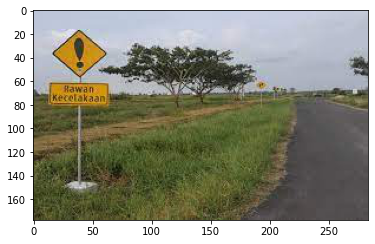

In [ ]:
image = Image.open('rambu.jpg')
plt.imshow(image)
predictions = predict(image)
print(predictions)
if predictions[0][1] == 1:
 print('vehicle')
elif predictions[0][0] == 1:
 print('nonvehicle')

Model belum bisa menebak objek non vehicle dengan baik

## 11 - Kesimpulan

Exploratory Data Analysis:
- Terdapat 2 tipe gambar yang diklasifikasi : vehicle dan non vehicle
- Didalam vehicle, gambar berupa: gambar belakang mobil
- non vehicle terdiri dari: jalan, dan pembatas jalan
- Vehicle dan non vehicle mempunya shape (tinggi :64, lebar :64, Channel : 3 (RGB))
- Rasio dari kedua dataset cukup seimbang (Balance), dimana vehicle dan non vehicle rasionya adalah 1 : 1 atau masing-masing kelas memilki dataset sekitar 8000


Evaluasi Model
- Model terbaik adalah model 3 (model yang telah di dikembangkan dari base model) dengan total convulution layer berjumlah 5, flatten layer 1, dan 1 fully connected layer
- Dikarenakan, Nilai akurasi paling tinggi yaitu (0.99) dan juga False Positive paling rendah
- Berdasarkan nilai yang tercantum di dalam classification report model ini sudah sangat baik, dimana model dapat membedakan mana yang non vehicle dan vehicle
- Akan tetapi, saat dimasukkan ke data inference, model ini cenderung menebak vehicle tetapi untuk non vehicle model ini belum menebaknya dengan baik
- Dari data inference, ada kemungkinan jika model masih belum stabil
